# Excess mortality in Russia due to the war in Ukraine

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

plt.style.use("mpl_style.txt")

In [2]:
df = pd.read_csv('deaths-by-age-gender-region-year-1990-2022.csv.gz')

df

,Region,Year,Age,Gender,Deaths
0,Алтайский край,1990,0-4 лет,f,264
1,Алтайский край,1990,0-4 лет,m,429
2,Алтайский край,1990,10-14 лет,f,28
3,Алтайский край,1990,10-14 лет,m,76
4,Алтайский край,1990,15-19 лет,f,63
...,...,...,...,...,...
112995,Ярославская область,2022,85 и более,m,807
112996,Ярославская область,2022,Всего,f,10264
112997,Ярославская область,2022,Всего,m,9202
112998,Ярославская область,2022,Неизвестно,f,1


In [3]:
# Load HIV deaths

df_hiv = pd.read_excel('deaths-hiv/RUS_HIV_deaths+mortality_1y_sex2006-2022.xlsx', sheet_name='Deaths_Age_V')

hiv_m = df_hiv.values[:101][:,1:18].astype(int)
hiv_f = df_hiv.values[:101][:,19:].astype(int)

hiv_m = hiv_m[:-1].reshape(-1, 5, hiv_m.shape[-1]).sum(axis=1)
hiv_f = hiv_f[:-1].reshape(-1, 5, hiv_f.shape[-1]).sum(axis=1)

hiv_years = np.arange(2006, 2023)

# Load population sizes

df_pop = pd.read_excel('deaths-hiv/RUS_HIV_deaths+mortality_1y_sex2006-2022.xlsx', sheet_name='Pop')

pop_m = df_pop.values[:101][:,1:19].astype(int)
pop_m = np.delete(pop_m, 9, axis=1)
pop_f = df_pop.values[:101][:,21:-1].astype(int)
pop_f = np.delete(pop_f, 9, axis=1)

pop_m = pop_m[:-1].reshape(-1, 5, pop_m.shape[-1]).sum(axis=1)
pop_f = pop_f[:-1].reshape(-1, 5, pop_f.shape[-1]).sum(axis=1)

Excess over 7 groups: 23,594


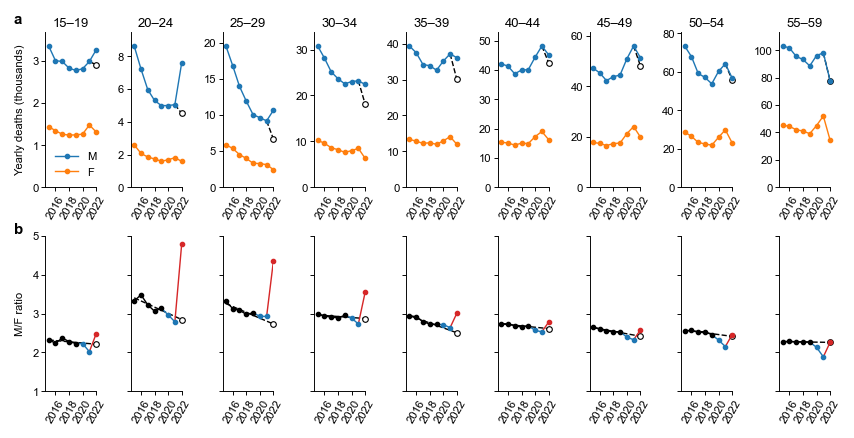

In [6]:
region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

# war = [344, 2848, 2865, 2998, 2577, 1943, 1238, 532, 201]

LinReg = LinearRegression()

# from scipy.optimize import curve_fit

excess = 0

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
#     male[:,1] -= hiv_m[3 + i, hiv_years >= 2015]
#     female[:,1] -= hiv_f[3 + i, hiv_years >= 2015]

#     male[-1,1] -= war[i]
    
    # Do computations
    x = np.arange(2015, 2023)
    ratio = male[:,1] / female[:,1]
    
#     ratio = (male[:,1] / pop_m[3 + i, hiv_years >= 2015]) / (female[:,1] / pop_f[3 + i, hiv_years >= 2015])
    
    LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
    yhat = LinReg.predict(x[-8:].reshape(-1,1))

#     LinReg.fit(x[-8:-3].reshape(-1,1), np.log(ratio[-8:-3] - 1).reshape(-1,1))
#     yhat = LinReg.predict(x[-8:].reshape(-1,1))
#     yhat = np.exp(yhat) + 1

    # def expfunc(x, a, b, c):
    #     return np.exp(a * x + b) + c
    # bh, bc = curve_fit(expfunc, x[-8:-3], ratio[-8:-3], p0=(-0.01, 0, 1))
    # yhat = expfunc(x[-8:], *bh).reshape(-1,1)
    
    baseline = yhat[-1,0] * female[-1,1] / 1000
    
#     baseline = yhat[-1,0] * female[-1,1] / pop_f[3+i, -1] * pop_m[3+i, -1] / 1000
    
    if i <= 6:
        excess += male[-1,1] - baseline * 1000
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, '.-', label='М', clip_on = False)
    ax1.plot(x, female[:,1] / 1000, '.-', label='F', clip_on = False)
    
    ax1.plot(x[-2:], [male[-2,1]/1000, baseline], '--', color='k', zorder=-2)
    ax1.plot(x[-1], baseline, 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([2016, 2018, 2020, 2022])
    ax1.set_xlim([2014.5, 2022])
    ax1.set_xticklabels([2016, 2018, 2020, 2022], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend()
        ax1.set_ylabel(r'Yearly deaths (thousands)')
        ax1.set_yticks([0, 1, 2, 3])

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-3], ratio[:-3], 'k.-')
    ax2.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax2.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
        
    ax2.plot(x[-8:], yhat, '--', color='k', zorder=-2)
    ax2.plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
                            
    ax2.set_ylim([1,5])        
    ax2.set_xticks([2016, 2018, 2020, 2022])
    ax2.set_xlim([2014.5, 2022])
    ax2.set_xticklabels([2016, 2018, 2020, 2022], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 

#     ax2.text(2015, 4, f'R: {war[i]}')
#     ax2.text(2015, 4.5, f'E: {male[-1,1] - baseline * 1000:.0f}')
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

# fig.savefig('figures/paper/mainfig-rates.png')
# fig.savefig('figures/paper/mainfig.pdf')

print(f'Excess over 7 groups: {excess:,.0f}')

Excess over 7 groups: 20,618


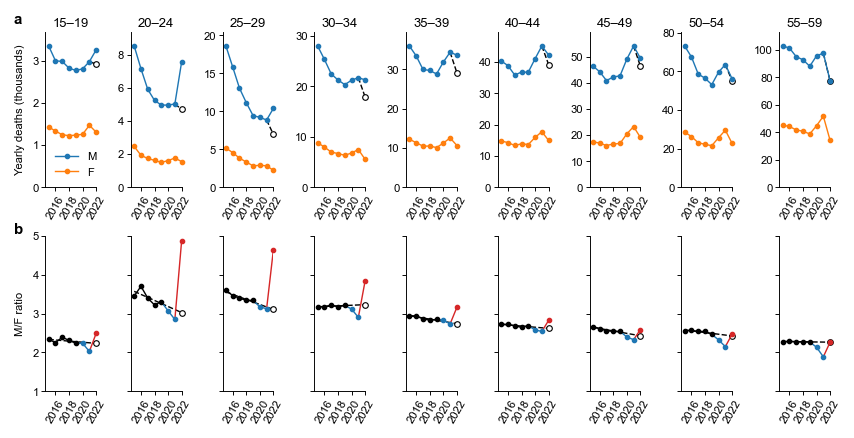

In [44]:
region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

# war = [344, 2848, 2865, 2998, 2577, 1943, 1238, 532, 201]

LinReg = LinearRegression()

# from scipy.optimize import curve_fit

excess = 0

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    male[:,1] -= hiv_m[3 + i, hiv_years >= 2015]
    female[:,1] -= hiv_f[3 + i, hiv_years >= 2015]

#     male[-1,1] -= war[i]
    
    # Do computations
    x = np.arange(2015, 2023)
    ratio = male[:,1] / female[:,1]
    
#     ratio = (male[:,1] / pop_m[3 + i, hiv_years >= 2015]) / (female[:,1] / pop_f[3 + i, hiv_years >= 2015])
    
    LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
    yhat = LinReg.predict(x[-8:].reshape(-1,1))

#     LinReg.fit(x[-8:-3].reshape(-1,1), np.log(ratio[-8:-3] - 1).reshape(-1,1))
#     yhat = LinReg.predict(x[-8:].reshape(-1,1))
#     yhat = np.exp(yhat) + 1

    # def expfunc(x, a, b, c):
    #     return np.exp(a * x + b) + c
    # bh, bc = curve_fit(expfunc, x[-8:-3], ratio[-8:-3], p0=(-0.01, 0, 1))
    # yhat = expfunc(x[-8:], *bh).reshape(-1,1)
    
    baseline = yhat[-1,0] * female[-1,1] / 1000
    
#     baseline = yhat[-1,0] * female[-1,1] / pop_f[3+i, -1] * pop_m[3+i, -1] / 1000
    
    if i <= 6:
        excess += male[-1,1] - baseline * 1000
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, '.-', label='М', clip_on = False)
    ax1.plot(x, female[:,1] / 1000, '.-', label='F', clip_on = False)
    
    ax1.plot(x[-2:], [male[-2,1]/1000, baseline], '--', color='k', zorder=-2)
    ax1.plot(x[-1], baseline, 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([2016, 2018, 2020, 2022])
    ax1.set_xlim([2014.5, 2022])
    ax1.set_xticklabels([2016, 2018, 2020, 2022], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend()
        ax1.set_ylabel(r'Yearly deaths (thousands)')
        ax1.set_yticks([0, 1, 2, 3])

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-3], ratio[:-3], 'k.-')
    ax2.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax2.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
        
    ax2.plot(x[-8:], yhat, '--', color='k', zorder=-2)
    ax2.plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
                            
    ax2.set_ylim([1,5])        
    ax2.set_xticks([2016, 2018, 2020, 2022])
    ax2.set_xlim([2014.5, 2022])
    ax2.set_xticklabels([2016, 2018, 2020, 2022], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 

#     ax2.text(2015, 4, f'R: {war[i]}')
#     ax2.text(2015, 4.5, f'E: {male[-1,1] - baseline * 1000:.0f}')
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/paper/mainfig-nohiv.png')
fig.savefig('figures/paper/mainfig-nohiv.pdf')

print(f'Excess over 7 groups: {excess:,.0f}')

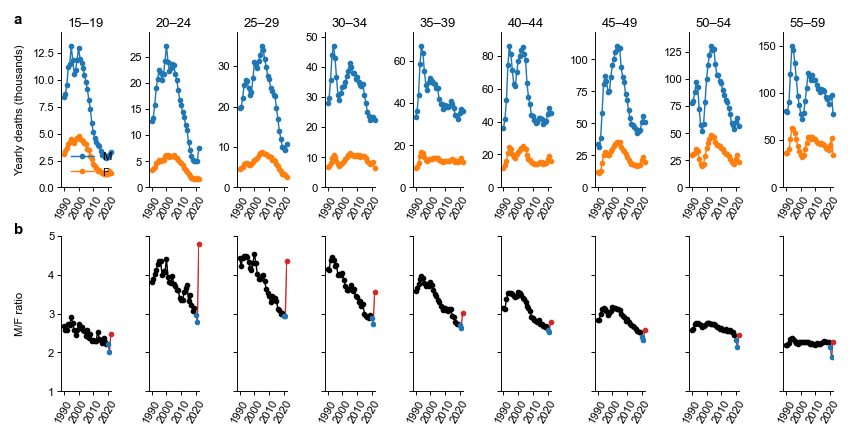

In [7]:
region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    # Do computations
    x = np.arange(1990, 2023)
    ratio = male[:,1] / female[:,1]
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, '.-', label='М', clip_on = False)
    ax1.plot(x, female[:,1] / 1000, '.-', label='F', clip_on = False)
    
    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([1990, 2000, 2010, 2020])
    ax1.set_xlim([1988, 2022])
    ax1.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax1.set_ylim([0, np.max(male[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend(loc='lower left')
        ax1.set_ylabel(r'Yearly deaths (thousands)')

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-3], ratio[:-3], 'k.-')
    ax2.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax2.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
                                    
    ax2.set_ylim([1,5])        
    ax2.set_xticks([1990, 2000, 2010, 2020])
    ax2.set_xlim([1988, 2022])
    ax2.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax2.set_yticks([1,2,3,4,5]) 
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/paper/suppfig-part1.png')
fig.savefig('figures/paper/suppfig-part1.pdf')

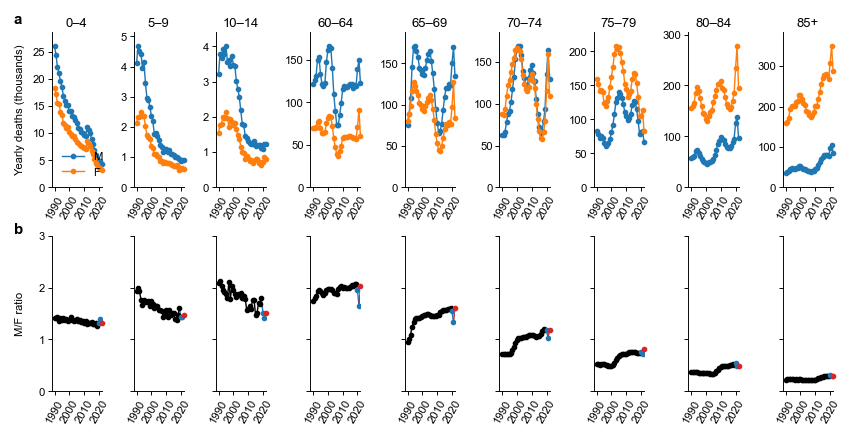

In [8]:
region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(6.2, 3.1))

agegroups = ['0-4 лет', '5-9 лет', '10-14 лет',
       '60-64 лет', '65-69 лет', '70-74 лет', '75-79 лет', 
       '80-84 лет', '85 и более']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]
agegroups_shortened[0] = '0–4'
agegroups_shortened[1] = '5–9'
agegroups_shortened[-1] = '85+'

LinReg = LinearRegression()

for i, age in enumerate(agegroups):
    # Get data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 1990)
    ][['Year', 'Deaths']].values
    
    # Do computations
    x = np.arange(1990, 2023)
    ratio = male[:,1] / female[:,1]
    
    # Plot
    ax1 = axs.flatten()[i]
    ax2 = axs.flatten()[i + len(agegroups)]

    ax1.plot(x, male[:,1] / 1000, '.-', label='М', clip_on = False)
    ax1.plot(x, female[:,1] / 1000, '.-', label='F', clip_on = False)
    
    ax1.set_title(agegroups_shortened[i])
    ax1.set_xticks([1990, 2000, 2010, 2020])
    ax1.set_xlim([1988, 2022])
    ax1.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax1.set_ylim([0, np.max(np.maximum(male, female)[:,1] / 1000) * 1.1])
            
    if i == 0:
        ax1.legend(loc='lower left')
        ax1.set_ylabel(r'Yearly deaths (thousands)')

        ax2.set_ylabel(r'M/F ratio')
    else:
        ax2.set_yticklabels([])
    
    ax2.plot(x[:-3], ratio[:-3], 'k.-')
    ax2.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax2.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax2.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax2.plot(x[-1], ratio[-1], '.', color='tab:red', clip_on=False)
                                    
    ax2.set_ylim([0, 3])        
    ax2.set_xticks([1990, 2000, 2010, 2020])
    ax2.set_xlim([1988, 2022])
    ax2.set_xticklabels([1990, 2000, 2010, 2020], rotation=60)
    ax2.set_yticks([0, 1, 2, 3]) 
    
fig.align_ylabels()

fig.text(.005, .97, 'a', fontsize=8, weight='bold')
fig.text(.005, .47, 'b', fontsize=8, weight='bold')

fig.savefig('figures/paper/suppfig-part2.png')
fig.savefig('figures/paper/suppfig-part2.pdf')

## Different model specifications

In [29]:
region = 'Российская Федерация'

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

LinReg = LinearRegression()

excess = np.zeros((len(agegroups), 6))

for i, age in enumerate(agegroups):
    # Get the data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2006)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2006)
    ][['Year', 'Deaths']].values
    
    # HIV subtraction
    male[:,1] -= hiv_m[3 + i, hiv_years >= 2006]
    female[:,1] -= hiv_f[3 + i, hiv_years >= 2006]
    
    ratio = male[:,1] / female[:,1]
    x = np.arange(2000, 2023)
    
    for j, fit_length in enumerate([5, 10]):
        beg = fit_length + 3
    
        # Perform the linear fit and extrapolate        
        LinReg.fit(x[-beg:-3].reshape(-1,1), ratio[-beg:-3].reshape(-1,1))
        yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
        excess[i, j*2] = male[-1,1] - yhat_sklearn[-1][0] * female[-1,1]
    
        # Compute the uncertainty
        X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
        y = ratio[-beg:].reshape(-1,1)
        beta = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3]) @ X[-beg:-3].T @ y[-beg:-3]
        yhat = X[-beg:] @ beta
        sigma2 = np.sum((y[-beg:-3] - yhat[-beg:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
        S = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3])
        predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
        predictive_std = np.sqrt(predictive_var[0][0]) 
        excess[i, j*2 + 1] = predictive_std * female[-1,1]
    
        assert(np.allclose(yhat, yhat_sklearn))
        
    excess[i, 4] = male[-1,1] - ratio[-4] * female[-1,1]
    excess[i, 5] = 0

for i in range(len(excess)):
    print(f'{agegroups[i]}:      {excess[i,0]:5.0f} +- {excess[i,1]:4.0f}'
          f'         {excess[i,2]:5.0f} +- {excess[i,3]:4.0f}'
          f'         {excess[i,4]:5.0f}')

total_std_5 = np.sqrt(np.sum(excess[:-2,1]**2))
total_std_10 = np.sqrt(np.sum(excess[:-2,3]**2))
    
print(f'\nTotal (15--49): {np.sum(excess[:-2,0]):5.0f} +- {total_std_5:4.0f}'
      f'         {np.sum(excess[:-2,2]):5.0f} +- {total_std_10:4.0f}'
      f'         {np.sum(excess[:-2,4]):5.0f}')

15-19 лет:        337 +-  123           273 +-  132           331
20-24 лет:       2868 +-  329          2406 +-  366          2438
25-29 лет:       3438 +-  137          2984 +-  258          2913
30-34 лет:       3395 +-  174          4245 +-  419          3501
35-39 лет:       4466 +-  400          4725 +-  627          3279
40-44 лет:       3064 +-  511          3768 +-  506          2026
45-49 лет:       3049 +-  593          3387 +-  477           887
50-54 лет:       1038 +-  781           -58 +-  615           148
55-59 лет:         61 +-  379         -1589 +-  621           -72

Total (15--49): 20618 +-  972         21788 +- 1127         15375


In [43]:
region = 'Российская Федерация'

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

LinReg = LinearRegression()

excess = np.zeros((len(agegroups), 2, 2, 3))
uncert = np.zeros_like(excess)

for h, hiv in enumerate([False, True]):
    for i, age in enumerate(agegroups):
        # Get the data
        male = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'm') & 
            (df.Year >= 2006)
        ][['Year', 'Deaths']].values

        female = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'f') & 
            (df.Year >= 2006)
        ][['Year', 'Deaths']].values

        if hiv:
            male[:,1] -= hiv_m[3 + i, hiv_years >= 2006]
            female[:,1] -= hiv_f[3 + i, hiv_years >= 2006]

        ratio = male[:,1] / female[:,1]
        x = np.arange(2006, 2023)

        for j, fit_length in enumerate([1, 5, 10]):
            beg = fit_length + 3

            # Perform the linear fit and extrapolate        
            LinReg.fit(x[-beg:-3].reshape(-1,1), ratio[-beg:-3].reshape(-1,1))
            yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
            excess[i, h, 0, j] = male[-1,1] - yhat_sklearn[-1][0] * female[-1,1]
            
            # Compute the uncertainty
            if fit_length > 1:
                X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
                y = ratio[-beg:].reshape(-1,1)
                beta = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3]) @ X[-beg:-3].T @ y[-beg:-3]
                yhat = X[-beg:] @ beta
                assert(np.allclose(yhat, yhat_sklearn))

                sigma2 = np.sum((y[-beg:-3] - yhat[-beg:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
                S = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3])
                predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
                predictive_std = np.sqrt(predictive_var[0][0]) 
                uncert[i, h, 0, j] = predictive_std * female[-1,1]

            # Perform exponential fit and extrapolate
            LinReg.fit(x[-beg:-3].reshape(-1,1), np.log(ratio[-beg:-3] - 1).reshape(-1,1))
            yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
            yhat_sklearn = np.exp(yhat_sklearn) + 1
            excess[i, h, 1, j] = male[-1,1] - yhat_sklearn[-1][0] * female[-1,1]
            
            # Compute the uncertainty
            if fit_length > 1:
                X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
                y = np.log(ratio[-beg:] - 1).reshape(-1,1)
                beta = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3]) @ X[-beg:-3].T @ y[-beg:-3]
                yhat = X[-beg:] @ beta
                assert(np.allclose(yhat, np.log(yhat_sklearn - 1)))

                sigma2 = np.sum((y[-beg:-3] - yhat[-beg:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
                S = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3])
                predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
                predictive_std = np.sqrt(predictive_var[0][0]) 
                predictive_std = np.max((
                    np.exp(yhat + predictive_std) - np.exp(yhat), 
                    np.exp(yhat) - np.exp(yhat - predictive_std)
                ))
                uncert[i, h, 1, j] = predictive_std * female[-1,1]

print('                               RAW                 |              HIV subtracted') 
print('                 1lin  5lin 10lin  1exp  5exp 10exp  1lin  5lin 10lin  1exp  5exp 10exp') 
print('---------------------------------------------------------------------------------------')

for i in range(len(excess)):
    print(f'{agegroups[i]}:      ', end='')
    for h in range(2):
        for e in range(2):
            for j in range(3):
                print(f'{excess[i,h,e,j]:5.0f} ', end='')
    print(f'\n              +-', end='')
    for h in range(2):
        for e in range(2):
            for j in range(3):
                print(f' {uncert[i,h,e,j]:4.0f} ', end='')
    print('\n')
print('---------------------------------------------------------------------------------------')
print('Total (15--49): ', end='')
for h in range(2):
    for e in range(2):
        for j in range(3):
            print(f'{np.sum(excess[:-2,h,e,j]):5.0f} ', end='')
print(f'\n              +-', end='')
for h in range(2):
    for e in range(2):
        for j in range(3):
            print(f' {np.sqrt(np.sum(uncert[:-2,h,e,j]**2)):4.0f} ', end='')

                               RAW                 |              HIV subtracted
                 1lin  5lin 10lin  1exp  5exp 10exp  1lin  5lin 10lin  1exp  5exp 10exp
---------------------------------------------------------------------------------------
15-19 лет:        329   353   292   329   352   293   331   337   273   331   337   275 
              +-    0   117   129     0   123   132     0   123   132     0   129   135 

20-24 лет:       2610  3069  2681  2610  3022  2681  2438  2868  2406  2438  2828  2416 
              +-    0   266   355     0   289   394     0   329   366     0   354   396 

25-29 лет:       3259  3961  3675  3259  3877  3619  2913  3438  2984  2913  3389  2979 
              +-    0   224   250     0   235   288     0   137   258     0   139   276 

30-34 лет:       3738  4264  5645  3738  4256  5375  3501  3395  4245  3501  3394  4200 
              +-    0   362   555     0   372   642     0   174   419     0   178   444 

35-39 лет:       3437  6047

## Deaths from external causes

<IPython.core.display.Javascript object>


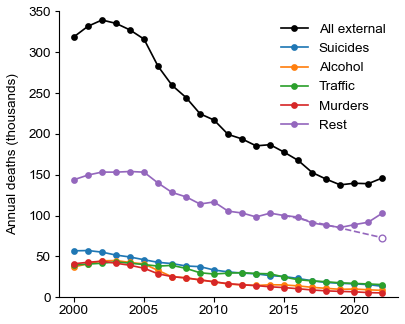

Excess in rest: 29885
Excess in all: 41439


In [176]:
df_causes = pd.read_excel('deaths-by-cause-region-year/fedstat31620.xls')

external = df_causes.values[363][26::3]  / 1000
traffic  = df_causes.values[580][26::3]  / 1000
suicides = df_causes.values[1357][26::3] / 1000
alcohol  = df_causes.values[1477][26::3] / 1000
murders  = df_causes.values[1702][26::3] / 1000

rest = external - suicides - alcohol - traffic - murders
 
years = np.arange(2000, 2023)

fig = plt.figure(figsize=(2.5, 2))

plt.plot(years, external, 'k.-', label='All external')
plt.plot(years, suicides, '.-', label='Suicides')
plt.plot(years, alcohol, '.-', label='Alcohol')
plt.plot(years, traffic, '.-', label='Traffic')
plt.plot(years, murders, '.-', label='Murders')
restline = plt.plot(years, rest, '.-', label='Rest')

LinReg = LinearRegression()
LinReg.fit(years[-8:-3].reshape(-1,1), rest[-8:-3].reshape(-1,1))
yhat = LinReg.predict(years[-8:].reshape(-1,1)).flatten()
plt.plot(years[-8:], yhat, '--', zorder=0, color=restline[0].get_color())
plt.plot(years[-1], yhat[-1], 'o', color='w', markeredgecolor=restline[0].get_color(),
            markersize=3, markeredgewidth=.6)

print(f'Excess in rest: {(rest[-1] - yhat[-1]) * 1000:.0f}')

LinReg.fit(years[-8:-3].reshape(-1,1), external[-8:-3].reshape(-1,1))
yhat = LinReg.predict(years[-8:].reshape(-1,1)).flatten()

print(f'Excess in all: {(external[-1] - yhat[-1]) * 1000:.0f}')

plt.ylabel('Annual deaths (thousands)')
plt.legend()
plt.ylim([0, 350])

plt.savefig('figures/paper/external.pdf')
plt.savefig('figures/paper/external.png')

<IPython.core.display.Javascript object>


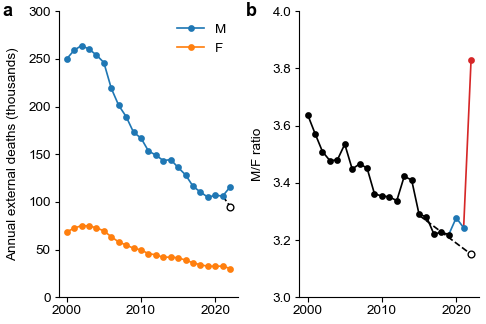

Excess (based on  5-year trend): 20562 +- 767
Excess (based on 10-year trend): 20095 +- 1727


In [5]:
df_external = pd.read_excel('external-deaths-by-gender-year/external-deaths.xlsx', skiprows=1)

male = df_external.values[:,2]
female = df_external.values[:,3]
years = np.arange(2000, 2023)

# male[-1] -= 15606

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(3, 2))

axs[0].plot(years, male / 1000, '.-', label='M')
axs[0].plot(years, female / 1000, '.-', label='F')
axs[0].set_ylim([0, 300])
axs[0].set_ylabel('Annual external deaths (thousands)')
axs[0].legend()

ratio = male / female

axs[1].plot(years[:-3], ratio[:-3], 'k.-')
axs[1].plot(years[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
axs[1].plot(years[-3:-1], ratio[-3:-1], '.', color='tab:blue')
axs[1].plot(years[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
axs[1].plot(years[-1], ratio[-1], '.', color='tab:red', clip_on=False)

axs[1].set_ylim([3, 4])
axs[1].set_ylabel(r'M/F ratio')

# Do computations
x = np.arange(2015, 2023)
LinReg = LinearRegression()
LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
yhat = LinReg.predict(x[-8:].reshape(-1,1))
baseline = yhat[-1,0] * female[-1] / 1000

axs[0].plot(x[-2:], [male[-2]/1000, baseline], '--', color='k', zorder=-2)
axs[0].plot(x[-1], baseline, 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

axs[1].plot(x[-8:], yhat, '--', color='k', zorder=-2)
axs[1].plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)

fig.text(.005, .95, 'a', fontsize=8, weight='bold')
fig.text(.505, .95, 'b', fontsize=8, weight='bold')

fig.savefig('figures/paper/external-gender.png')
fig.savefig('figures/paper/external-gender.pdf')

for fit_length in [5, 10]:
    x = years
    beg = fit_length + 3

    # Perform the linear fit and extrapolate
    LinReg.fit(x[-beg:-3].reshape(-1,1), ratio[-beg:-3].reshape(-1,1))
    yhat_sklearn = LinReg.predict(x[-beg:].reshape(-1,1))
    excess = male[-1] - yhat_sklearn[-1][0] * female[-1]

    # Compute the uncertainty
    X = np.concatenate((x[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
    y = ratio[-beg:].reshape(-1,1)
    beta = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3]) @ X[-beg:-3].T @ y[-beg:-3]
    yhat = X[-beg:] @ beta
    sigma2 = np.sum((y[-beg:-3] - yhat[-beg:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
    S = np.linalg.pinv(X[-beg:-3].T @ X[-beg:-3])
    predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
    predictive_std = np.sqrt(predictive_var[0][0]) 
    excess_std = predictive_std * female[-1]

    assert(np.allclose(yhat, yhat_sklearn))

    print(f'Excess (based on {fit_length:2}-year trend): {excess:.0f} +- {excess_std:.0f}')

## Male excess per region

In [3]:
# ISO codes and region names

df_iso = pd.read_csv('regions-codes-names.csv')
df_iso

,ISO,Russian name,English name long,English name short,English name
0,RU-AD,Республика Адыгея,"Adygeya, Respublika",Adygea,Adygea
1,RU-AL,Республика Алтай,"Altay, Respublika",Altai Republic,Altai Republic
2,RU-BA,Республика Башкортостан,"Bashkortostan, Respublika",Bashkortostan,Bashkortostan
3,RU-BU,Республика Бурятия,"Buryatiya, Respublika",Buryatia,Buryatia
4,RU-CE,Чеченская Республика,Chechenskaya Respublika,Chechnya,Chechnya
...,...,...,...,...,...
81,RU-NEN,Ненецкий АО,Nenetskiy avtonomnyy okrug,Nenets,Nenets AO
82,RU-YAN,Ямало-Hенецкий АО,Yamalo-Nenetskiy avtonomnyy okrug,Yamalo-Nenets,Yamalo-Nenets AO
83,UA-40,Севастополь,Sevastopol,Sevastopol,Sevastopol
84,UA-43,Республика Крым,Autonomous Republic of Crimea,Crimea,Crimea


In [4]:
def get_excess(region):
    LinReg = LinearRegression()
    
    agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
                 '30-34 лет', '35-39 лет', '40-44 лет', 
                 '45-49 лет']
        
    excess_male = 0
    total_baseline = 0
    excess_male_var = 0

    for age in agegroups:
        male = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'm') & 
            (df.Year >= 2015)
        ][['Year', 'Deaths']].values
    
        female = df[
            (df.Region == region) & 
            (df.Age == age) & 
            (df.Gender == 'f') & 
            (df.Year >= 2015)
        ][['Year', 'Deaths']].values
        
        # Add +1 to the denominator
        ratio = male[:,1] / (1 + female[:,1])

        LinReg.fit(male[:5, 0].reshape(-1,1), ratio[:5].reshape(-1,1))
        
        ratio_hat = LinReg.predict(male[-1, 0].reshape(-1,1))[0][0]
        # If the predicted ratio is <1, just say it's 1
        if ratio_hat < 1:
            ratio_hat = 1
        yhat = (1 + female[-1,1]) * ratio_hat  
        excess_male += male[-1,1] - yhat
        total_baseline += yhat
        
        # Compute the uncertainty
        X = np.concatenate((male[-8:,0].reshape(-1,1), np.ones((8,1))), axis=1)
        y = ratio[-8:].reshape(-1,1)
        beta = np.linalg.pinv(X[-8:-3].T @ X[-8:-3]) @ X[-8:-3].T @ y[-8:-3]
        yhat = X[-8:] @ beta
        sigma2 = np.sum((y[-8:-3] - yhat[-8:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
        S = np.linalg.pinv(X[-8:-3].T @ X[-8:-3])
        predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
        excess_male_var += predictive_var[0][0] * (1 + female[-1,1])**2
    
    excess_pratio = excess_male / total_baseline
    
    z = excess_male / np.sqrt(excess_male_var)
        
    return excess_male, excess_pratio, np.sqrt(excess_male_var), z 

regions = df.Region.unique()
excess_regional = np.zeros((regions.size, 4))
for i, region in enumerate(regions):
    print('.', end='')
    excess_regional[i] = get_excess(region)

........................................................................................

In [5]:
for i in range(regions.size):
    # Skipping two regions that contain AOs. Will only use them without AOs.
    if regions[i] in ['Архангельская область', 'Тюменская область']:
        continue
    
    iso = df_iso[df_iso['Russian name'] == regions[i]].ISO.values[0]
    
    print(f'{iso:10} {regions[i]:30} {round(excess_regional[i,0]/10)*10:5.0f} +- '
          f'{round(excess_regional[i,2]/10)*10:4.0f} '
          f'(z = {excess_regional[i,3]:4.1f})   P = {excess_regional[i,1]*100:3.0f}%')

RU-ALT     Алтайский край                   330 +-  150 (z =  2.2)   P =  12%
RU-AMU     Амурская область                 500 +-   90 (z =  5.5)   P =  57%
RU-ARK     Архангельская область без АО     170 +-  100 (z =  1.7)   P =  15%
RU-AST     Астраханская область             190 +-   70 (z =  2.5)   P =  22%
RU-BEL     Белгородская область             370 +-  100 (z =  3.7)   P =  29%
RU-BRY     Брянская область                 180 +-  100 (z =  1.9)   P =  13%
RU-VLA     Владимирская область             270 +-  110 (z =  2.4)   P =  16%
RU-VGG     Волгоградская область            510 +-  120 (z =  4.2)   P =  22%
RU-VLG     Вологодская область             -170 +-   80 (z = -2.0)   P = -11%
RU-VOR     Воронежская область              460 +-  140 (z =  3.3)   P =  19%
RU-YEV     Еврейская АО                      70 +-   30 (z =  2.6)   P =  35%
RU-ZAB     Забайкальский край               250 +-   90 (z =  2.9)   P =  15%
RU-IVA     Ивановская область               240 +-   60 (z =  4.

In [223]:
# Top 10

for i in np.argsort(excess_regional[:,0])[::-1][:10]:
    print(f'{regions[i]:30} {round(excess_regional[i,0]/10)*10:5.0f} +- '
          f'{round(excess_regional[i,2]/10)*10:4.0f} '
          f'(z = {excess_regional[i,3]:4.1f})   P = {excess_regional[i,1]*100:3.0f}%')
    
print('')
    
for i in np.argsort(excess_regional[:,3])[::-1][:10]:
    print(f'{regions[i]:30} {round(excess_regional[i,0]/10)*10:5.0f} +- '
          f'{round(excess_regional[i,2]/10)*10:4.0f} '
          f'(z = {excess_regional[i,3]:4.1f})   P = {excess_regional[i,1]*100:3.0f}%')
    
print('')
    
for i in np.argsort(excess_regional[:,1])[::-1][:10]:
    print(f'{regions[i]:30} {round(excess_regional[i,0]/10)*10:5.0f} +- '
          f'{round(excess_regional[i,2]/10)*10:4.0f} '
          f'(z = {excess_regional[i,3]:4.1f})   P = {excess_regional[i,1]*100:3.0f}%')

Российская Федерация           23600 +- 1110 (z = 21.3)   P =  15%
Ростовская область              1510 +-  190 (z =  8.1)   P =  38%
Свердловская область            1140 +-  200 (z =  5.8)   P =  22%
Москва                          1060 +-  410 (z =  2.6)   P =  12%
Новосибирская область            880 +-  140 (z =  6.1)   P =  28%
Удмуртская Республика            700 +-  100 (z =  6.8)   P =  53%
Пермский край                    690 +-  180 (z =  3.9)   P =  22%
Челябинская область              670 +-  210 (z =  3.2)   P =  17%
Нижегородская область            670 +-  170 (z =  3.9)   P =  18%
Республика Дагестан              650 +-   80 (z =  7.8)   P =  77%

Российская Федерация           23600 +- 1110 (z = 21.3)   P =  15%
Ростовская область              1510 +-  190 (z =  8.1)   P =  38%
Республика Дагестан              650 +-   80 (z =  7.8)   P =  77%
Удмуртская Республика            700 +-  100 (z =  6.8)   P =  53%
Новосибирская область            880 +-  140 (z =  6.1)   P =

In [10]:
# LaTeX code

# Alphabetical order of ISO regions
# (Two regions that contain AOs are in the ISO table only without AOs.)
isos = list(np.sort(df_iso.ISO))
# Move Russian Federation to the end 
isos = isos[1:] + [isos[0]]

for iso in isos:
    rus = df_iso[df_iso['ISO'] == iso]['Russian name'].values[0]
    eng = df_iso[df_iso['ISO'] == iso]['English name'].values[0]
    i = np.where(regions == rus)[0][0]
        
    print(f'{iso:8} & {eng:25} & '
          f'${round(excess_regional[i,0]/10)*10:5.0f}$ & '
          f'${round(excess_regional[i,2]/10)*10:4.0f}$ & '
          f'${excess_regional[i,3]:4.1f}$ & '
          f'${excess_regional[i,1]*100:4.0f}$\% \\\\')

RU-AD    & Adygea                    & $  -80$ & $  60$ & $-1.3$ & $ -15$\% \\
RU-AL    & Altai Republic            & $   10$ & $  60$ & $ 0.2$ & $   4$\% \\
RU-ALT   & Altai Krai                & $  330$ & $ 150$ & $ 2.2$ & $  12$\% \\
RU-AMU   & Amur Oblast               & $  500$ & $  90$ & $ 5.5$ & $  57$\% \\
RU-ARK   & Arkhangelsk Oblast        & $  170$ & $ 100$ & $ 1.7$ & $  15$\% \\
RU-AST   & Astrakhan Oblast          & $  190$ & $  70$ & $ 2.5$ & $  22$\% \\
RU-BA    & Bashkortostan             & $  610$ & $ 190$ & $ 3.2$ & $  14$\% \\
RU-BEL   & Belgorod Oblast           & $  370$ & $ 100$ & $ 3.7$ & $  29$\% \\
RU-BRY   & Bryansk Oblast            & $  180$ & $ 100$ & $ 1.9$ & $  13$\% \\
RU-BU    & Buryatia                  & $  360$ & $ 110$ & $ 3.2$ & $  27$\% \\
RU-CE    & Chechnya                  & $  400$ & $  70$ & $ 6.0$ & $ 104$\% \\
RU-CHE   & Chelyabinsk Oblast        & $  670$ & $ 210$ & $ 3.2$ & $  17$\% \\
RU-CHU   & Chukotka AO               & $  -20$ & $  

In [46]:
# Export into a CSV

# Skipping two regions that contain AOs. Will only use them without AOs.
good = ~np.isin(regions, ['Архангельская область', 'Тюменская область'])

iso = [df_iso[df_iso['Russian name'] == r].ISO.values[0] for r in regions[good]]

df = pd.DataFrame({
    'ISO': iso,
    'Region': regions[good],
    'Excess': excess_regional[:, 0][good],
    'Excess standard error': excess_regional[:, 2][good],
    'Excess z-score': excess_regional[:, 3][good],
    'Excess P-score': excess_regional[:, 1][good],
})

df.to_csv('regional-excess-2022.csv', float_format='%.2f', index=False)

df

,ISO,Region,Excess,Excess standard error,Excess z-score,Excess P-score
0,RU-ALT,Алтайский край,331.179165,147.775544,2.241096,0.115200
1,RU-AMU,Амурская область,496.080251,89.523915,5.541315,0.572233
2,RU-ARK,Архангельская область без АО,173.489126,103.695275,1.673067,0.149365
3,RU-AST,Астраханская область,187.085110,73.665339,2.539663,0.215061
4,RU-BEL,Белгородская область,372.793181,99.898997,3.731701,0.289165
...,...,...,...,...,...,...
81,RU-CU,Чувашская Республика,113.398514,130.463710,0.869196,0.079211
82,RU-CHU,Чукотский АО,-16.865195,41.038980,-0.410956,-0.140701
83,RU-SA,Якутия,16.979581,78.258364,0.216968,0.014947
84,RU-YAN,Ямало-Hенецкий АО,-5.974401,74.945922,-0.079716,-0.010161


<IPython.core.display.Javascript object>


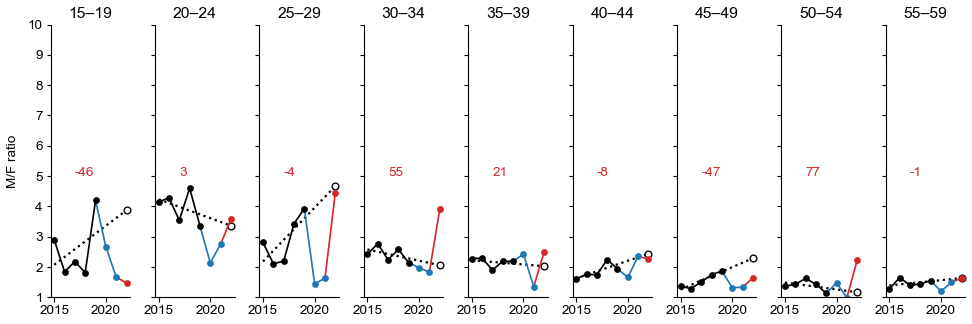

In [5]:
# Inspect one region at a time

region = 'Республика Тыва'

fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(6, 2), layout='constrained')

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

excess_male = []
excess_male_interval = []

for i, age in enumerate(agegroups):
    ax = axs.flatten()[i]

    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    ratio = male[:,1] / (1 + female[:,1])
    x = np.arange(2015, 2023)

    ax.plot(x[:-3], ratio[:-3], 'k.-')
    ax.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax.plot(x[-1], ratio[-1], '.', color='tab:red')
        
    LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
    yhat = LinReg.predict(x[-8:].reshape(-1,1))
    ax.plot(x[-8:], yhat, ':', lw=1, color='k', zorder=-2)
    ax.plot(x[-1], yhat[-1], 'o', color='w', markeredgecolor='k', 
            markersize = 3, markeredgewidth=.6, zorder=-2, clip_on=False)
    
    excess_male.append(male[-1,1] - yhat[-1][0] * (1 + female[-1,1]))
    
    ax.text(2017, 5, f'{male[-1,1] - yhat[-1][0] * (1 + female[-1,1]):.0f}', color='tab:red')
                        
    ax.set_title(agegroups_shortened[i])
    ax.set_ylim([1,10])
        
    if i == 0:
        ax.set_ylabel('M/F ratio')
    else:
        ax.set_yticklabels([])
        
plt.savefig(f'{region}.png')

### Relationship between three measures of regional war fatalities

In [25]:
df = pd.read_csv('regional-excess-2022.csv')
df1 = pd.read_csv('bbc-mediazona-regional-deaths-2022.csv')
df2 = pd.read_csv('pensii-po-potere-kormiltsa-regional-2022.csv')

df = pd.merge(df, df1[['ISO', 'bbc_mediazona_deaths']], on='ISO', how="inner")
df = pd.merge(df, df2[['ISO', 'Increase']], on='ISO', how="inner")

df = df.rename(columns={'Increase': 'Pensions'})

df

,ISO,Region,Excess,Excess standard error,Excess z-score,Excess P-score,bbc_mediazona_deaths,Pensions
0,RU-ALT,Алтайский край,331.18,147.78,2.24,0.12,226,285.0
1,RU-AMU,Амурская область,496.08,89.52,5.54,0.57,98,119.0
2,RU-ARK,Архангельская область без АО,173.49,103.70,1.67,0.15,127,98.0
3,RU-AST,Астраханская область,187.09,73.67,2.54,0.22,117,101.0
4,RU-BEL,Белгородская область,372.79,99.90,3.73,0.29,230,130.0
...,...,...,...,...,...,...,...,...
80,RU-CU,Чувашская Республика,113.40,130.46,0.87,0.08,143,104.0
81,RU-CHU,Чукотский АО,-16.87,41.04,-0.41,-0.14,11,NaN
82,RU-SA,Якутия,16.98,78.26,0.22,0.01,84,16.0
83,RU-YAN,Ямало-Hенецкий АО,-5.97,74.95,-0.08,-0.01,28,8.0


<IPython.core.display.Javascript object>


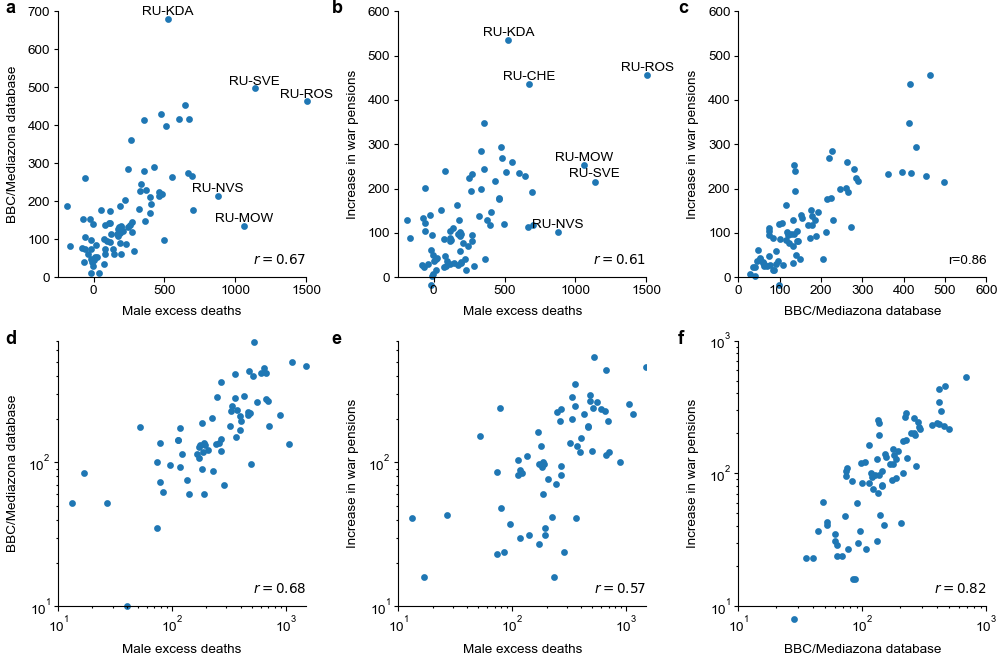

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.2, 4.1))

axs.flat[0].scatter(df.Excess, df.bbc_mediazona_deaths, clip_on=False)
axs.flat[0].set_xlim([-250, 1500])
axs.flat[0].set_ylim([0, 700])
axs.flat[0].set_xlabel('Male excess deaths')
axs.flat[0].set_ylabel('BBC/Mediazona database')

rho = np.corrcoef(df.Excess, df.bbc_mediazona_deaths)[0,1]
axs.flat[0].text(1, .05, f'$r={rho:.2f}$', transform=axs.flat[0].transAxes, ha='right')

ind = (df.Excess > 750) | (df.bbc_mediazona_deaths > 500)
for i in np.where(ind)[0]:
    axs.flat[0].text(df.Excess[i], df.bbc_mediazona_deaths[i] + 10, df.ISO[i], ha='center')

axs.flat[1].scatter(df.Excess, df.Pensions, clip_on=False)
axs.flat[1].set_xlim([-250, 1500])
axs.flat[1].set_ylim([0, 600])
axs.flat[1].set_xlabel('Male excess deaths')
axs.flat[1].set_ylabel('Increase in war pensions')

ind = ~df.Pensions.isna()
rho = np.corrcoef(df.Excess[ind], df.Pensions[ind])[0,1]
axs.flat[1].text(1, .05, f'$r={rho:.2f}$', transform=axs.flat[1].transAxes, ha='right')

ind = (df.Excess > 750) | (df.Pensions > 350)
for i in np.where(ind)[0]:
    axs.flat[1].text(df.Excess[i], df.Pensions[i] + 10, df.ISO[i], ha='center')

axs.flat[2].scatter(df.bbc_mediazona_deaths, df.Pensions, clip_on=False)
axs.flat[2].set_xlim([0, 600])
axs.flat[2].set_ylim([0, 600])
axs.flat[2].set_xlabel('BBC/Mediazona database')
axs.flat[2].set_ylabel('Increase in war pensions')

ind = ~df.Pensions.isna()
rho = np.corrcoef(df.bbc_mediazona_deaths[ind], df.Pensions[ind])[0,1]
axs.flat[2].text(1, .05, f'r={rho:.2f}', transform=axs.flat[2].transAxes, ha='right')

axs.flat[3].scatter(df.Excess, df.bbc_mediazona_deaths, clip_on=False)
axs.flat[3].set_xlim([10, 1500])
axs.flat[3].set_ylim([10, 700])
axs.flat[3].set_xscale('log')
axs.flat[3].set_yscale('log')
axs.flat[3].set_xlabel('Male excess deaths')
axs.flat[3].set_ylabel('BBC/Mediazona database')

ind = df.Excess > 0
rho = np.corrcoef(np.log(df.Excess[ind]), np.log(df.bbc_mediazona_deaths[ind]))[0,1]
axs.flat[3].text(1, .05, f'$r={rho:.2f}$', transform=axs.flat[3].transAxes, ha='right')

axs.flat[4].scatter(df.Excess, df.Pensions)
axs.flat[4].set_xlim([10, 1500])
axs.flat[4].set_ylim([10, 700])
axs.flat[4].set_xscale('log')
axs.flat[4].set_yscale('log')
axs.flat[4].set_xlabel('Male excess deaths')
axs.flat[4].set_ylabel('Increase in war pensions')

ind = (df.Excess > 0) & (df.Pensions > 0)
rho = np.corrcoef(np.log(df.Excess[ind]), np.log(df.Pensions[ind]))[0,1]
axs.flat[4].text(1, .05, f'$r={rho:.2f}$', transform=axs.flat[4].transAxes, ha='right')

axs.flat[5].scatter(df.bbc_mediazona_deaths, df.Pensions, clip_on=False)
axs.flat[5].set_xlim([10, 1000])
axs.flat[5].set_ylim([10, 1000])
axs.flat[5].set_xscale('log')
axs.flat[5].set_yscale('log')
axs.flat[5].set_xlabel('BBC/Mediazona database')
axs.flat[5].set_ylabel('Increase in war pensions')

ind = df.Pensions > 0
rho = np.corrcoef(np.log(df.bbc_mediazona_deaths[ind]), np.log(df.Pensions[ind]))[0,1]
axs.flat[5].text(1, .05, f'$r={rho:.2f}$', transform=axs.flat[5].transAxes, ha='right')

fig.align_ylabels()

fig.text(.005, .98, 'a', fontsize=8, weight='bold')
fig.text(.330, .98, 'b', fontsize=8, weight='bold')
fig.text(.675, .98, 'c', fontsize=8, weight='bold')
fig.text(.005, .48, 'd', fontsize=8, weight='bold')
fig.text(.330, .48, 'e', fontsize=8, weight='bold')
fig.text(.675, .48, 'f', fontsize=8, weight='bold')

fig.savefig('figures/paper/regions.png')
fig.savefig('figures/paper/regions.pdf')

In [30]:
# Total number of BBC/Mediazona deaths found or happened in 2022 

np.sum(df.bbc_mediazona_deaths)

14636

In [33]:
ratio = df.Excess / (df.bbc_mediazona_deaths)

ind = np.argsort(ratio).values[::-1]

for i in ind[:10]:
    print(f'{df.Region[i]:30} {ratio[i]:.1f}')

Москва                         7.9
Амурская область               5.1
Республика Мордовия            4.2
Новосибирская область          4.1
Ненецкий АО                    4.0
Удмуртская Республика          4.0
Ростовская область             3.3
Ханты-Мансийский АО            3.2
Севастополь                    2.7
Пермский край                  2.6
